In [1]:
import cv2
import pandas as pd
import numpy as np

def pre_processing(val=True):
    
    data = pd.read_csv('data/x_train_gr_smpl.csv')
    labels = pd.read_csv('data/y_train_smpl.csv')

    if(val):
        ## ---------------- Data preparation ---------------- ##
        X_train = []
        for i in range(data.shape[0]):
            img = np.uint8(data.iloc[i])
            edited = cv2.Canny(img, 10, 30)
            edited = cv2.GaussianBlur(edited, (5, 5), 0)
            X_train.append(edited.reshape((1,-1))[0])

        data = pd.DataFrame(X_train)
        ## -------------------------------------------------- ##

    return data, labels

In [2]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score

In [3]:
# Compare homogeneity score with different number of clusters

n_clusters = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50, 100]

data, labels = pre_processing()
labels = np.reshape(labels.values, newshape=(1, -1))

for n in n_clusters:
    estimator = KMeans(n_clusters=n, max_iter=50000, random_state=1, n_jobs=-1).fit(data)
    print(f'Number of clusters: {n} Homogeneity score: {homogeneity_score(labels[0], estimator.labels_)}')

Number of clusters: 10 Homogeneity score: 0.4941480704250148
Number of clusters: 11 Homogeneity score: 0.5159853723237561
Number of clusters: 12 Homogeneity score: 0.5146366127821865
Number of clusters: 13 Homogeneity score: 0.5278759052918507
Number of clusters: 14 Homogeneity score: 0.5333726747258547
Number of clusters: 15 Homogeneity score: 0.5640689586211225
Number of clusters: 16 Homogeneity score: 0.5555233531974998
Number of clusters: 17 Homogeneity score: 0.5837853645510892
Number of clusters: 18 Homogeneity score: 0.5969397137445074
Number of clusters: 19 Homogeneity score: 0.5946190526092541
Number of clusters: 20 Homogeneity score: 0.6082159882644707
Number of clusters: 50 Homogeneity score: 0.7032531269938882
Number of clusters: 100 Homogeneity score: 0.7508869983980473


In [4]:
# Compute the optimal number of clusters: Elbow method

import matplotlib.pyplot as plt


data, _ = pre_processing()
sum_of_squared_distances = []
n_clusters = [1, 4, 7, 10, 13, 16, 19, 30, 50, 100]

for k in n_clusters:
    estimator = KMeans(n_clusters=k).fit(data)
    sum_of_squared_distances.append(estimator.inertia_)

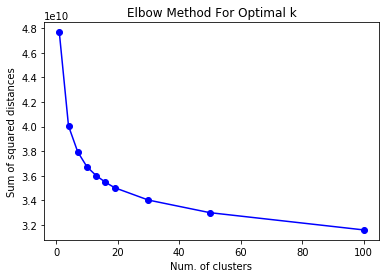

In [5]:
plt.plot(n_clusters, sum_of_squared_distances, 'bo-')
plt.xlabel('Num. of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [6]:
# Trying different algorithm: EM algorithm

from sklearn.mixture import GaussianMixture as EM


data, labels = pre_processing()

data['label'] = labels
data = data.sample(frac=1)

X = data.iloc[:, :-1]
y = data['label'] 

em = EM(n_components=10, max_iter=100, n_init=1).fit(X)
proba = em.predict_proba(X)
y_pred = em.predict(X)
print(homogeneity_score(y, y_pred))

0.48009917695252624


In [7]:
print(proba.shape)
print(proba[:10])

(12660, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [8]:
print(y_pred.shape)
print(y_pred[:10])

(12660,)
[0 3 7 7 6 9 6 2 6 5]


In [9]:
# Trying EM algorithm with the top 10 features dataset

from sklearn.mixture import GaussianMixture as EM


top_10_array = set()
data, _ = pre_processing()

for i in range(10):
    data = data.reindex(np.arange(data.shape[0]))
    labels = pd.read_csv(f'data/y_train_smpl_{i}.csv')
    data['label'] = labels
    data = data.sample(frac=1)

    corr_label = data.drop("label", axis=1).apply(lambda x: x.corr(data.label))
    corr_label = [(index, abs(corr_val), i) for index, corr_val in enumerate(corr_label)]
    corr_label = sorted(corr_label, key=lambda tup: tup[1], reverse=True)  # Order by correlation value

    for tup in corr_label[:10]:
        top_10_array.add(tup[0])

data, labels = pre_processing()
data_top_10 = data[data.columns[list(top_10_array)]].copy(deep=True)

data_top_10['label'] = labels
data_top_10 = data_top_10.sample(frac=1)

X = data_top_10.iloc[:, :-1]
y = data_top_10['label']

y_pred = EM(n_components=10, max_iter=100, n_init=1).fit_predict(X)
print(homogeneity_score(y, y_pred))

0.4951995652761089


In [10]:
# Trying different algorithm: Mean Shift algorithm

from sklearn.cluster import MeanShift


top_10_array = set()

data, _ = pre_processing()

for i in range(10):
    data = data.reindex(np.arange(data.shape[0]))
    labels = pd.read_csv(f'data/y_train_smpl_{i}.csv')
    data['label'] = labels
    data = data.sample(frac=1)
    
    corr_label = data.drop("label", axis=1).apply(lambda x: x.corr(data.label))
    corr_label = [(index, abs(corr_val), i) for index, corr_val in enumerate(corr_label)]
    corr_label = sorted(corr_label, key=lambda tup: tup[1], reverse=True)  # Order by correlation value
            
    for tup in corr_label[:10]:
        top_10_array.add(tup[0])
        
data, labels = pre_processing()
labels = np.reshape(labels.values, newshape=(1, -1))
data_top_10 = data[data.columns[list(top_10_array)]].copy(deep=True)

estimator = MeanShift().fit(data_top_10)
print(homogeneity_score(labels[0], estimator.labels_))

-4.3485283947296345e-16
